In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Tranzakciós adatok elemzése

In [2]:
odf=pd.read_csv("../data/DataSet_Tesco5000_withDaynum.csv", sep=";")

In [3]:
odf.head()

,customer_id,visit_date,visit_spend,daynum
0,2,2010-04-01,5.97,0
1,2,2010-04-06,12.71,5
2,2,2010-04-07,34.52,6
3,2,2010-04-12,7.89,11
4,2,2010-04-14,17.17,13


In [38]:
odf['hetnapja']=(odf['daynum']-3) % 7

In [34]:
def stat_hozzaado(cust_df, valtozo_neve, aggreg_mode, startnap, endnap,trx_df):
    c1= trx_df[trx_df['daynum']>=startnap]
    c2=c1[c1['daynum']<endnap]
    stat= c2.groupby('customer_id', as_index=False)['visit_spend'].agg(aggreg_mode)
    stat.columns=['customer_id', valtozo_neve]
    
    cust_df=cust_df.merge(stat, on='customer_id', how='left')
    cust_df[valtozo_neve]=cust_df[valtozo_neve].fillna(0)
    return cust_df

In [43]:
def adathalmaz_generalo (iu_nap, df):
    #célváltozó legyártása
    celnap1= df [df['daynum']>iu_nap ]
    celnap2= celnap1[ celnap1['daynum']<=iu_nap + 4]
    bejott_userek= pd.DataFrame({ 'customer_id':celnap2['customer_id'].unique() })
    bejott_userek['target']=1
    ujdf=pd.DataFrame({'customer_id': df['customer_id'].unique() })
    #print(len(ujdf))
    ujdf=ujdf.merge(bejott_userek, on='customer_id', how='left')
    ujdf['target']=ujdf['target'].fillna(0)
    
    #bemeno változók
    #múlt héten ugyanekkor hány tranzakció volt
    ujdf=stat_hozzaado(ujdf,"last_4day_trx_num", 'count', iu_nap-6, iu_nap-2, df)
    ujdf=stat_hozzaado(ujdf,"last_4day_trx_sum",
                       'sum',iu_nap-6,iu_nap-2,df)
    ujdf=stat_hozzaado(ujdf,"napi_betevo",
                       'sum',0,iu_nap,df)
    ujdf["napi_betevo"]=ujdf["napi_betevo"]/(iu_nap-1)
    
    for melyik_nap in range(0,7):
        minidf=df[df['hetnapja']==melyik_nap]
        ujdf=stat_hozzaado(ujdf, "4w_p_"+str(melyik_nap), 'count', iu_nap-28, iu_nap, minidf)
        ujdf["4w_p_"+str(melyik_nap)]=ujdf["4w_p_"+str(melyik_nap)] /4
    return ujdf
    
#itt elmélyedek egy hibában hosszasan de nem látom  
elemzesi_df=adathalmaz_generalo(200,odf)
elemzesi_df.head()

,customer_id,target,last_4day_trx_num,last_4day_trx_sum,napi_betevo,4w_p_0,4w_p_1,4w_p_2,4w_p_3,4w_p_4,4w_p_5,4w_p_6
0,2,1.0,1.0,1.50,4.879347,0.00,0.25,0.50,0.75,0.25,0.75,0.0
1,3,1.0,1.0,4.73,9.906382,0.75,0.25,0.25,0.00,0.50,0.00,1.0
2,4,1.0,1.0,80.00,25.187638,0.25,0.50,0.25,0.00,0.25,0.25,0.0
3,5,1.0,2.0,58.45,9.089196,0.00,0.50,0.25,0.25,0.00,0.50,0.0
4,6,0.0,0.0,0.00,8.461658,0.00,1.00,0.00,0.00,0.00,0.00,0.0


In [44]:
train_df1=adathalmaz_generalo(200-6, odf)
test_df=adathalmaz_generalo(200,odf).copy()

In [ ]:
all_train_df=[]
for i in range(1,4):
    train_df=adathalmaz_generalo(200-i*7,odf).copy()
    all_train_df.append(train_df)
    
train_df=
#itt elvesztettem
    

In [45]:
from sklearn.linear_model import LogisticRegression
modell= LogisticRegression()

In [47]:
bemeno_valtozok=train_df.columns[2:]

In [48]:
modell.fit(train_df[bemeno_valtozok], train_df['target'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [50]:
modell.intercept_
#neki ez -1 ami aggaszt

array([-0.81391423])

In [51]:
modell.coef_
#és ezek is mások

array([[ 3.53191435e-02,  1.98334134e-03,  2.81907188e-02,
        -1.75073395e-01, -2.45536387e-02, -3.32816019e-01,
         1.33213193e+00,  1.82353418e+00,  2.07635824e+00,
         1.47621557e+00]])

In [52]:
bemeno_valtozok

Index(['last_4day_trx_num', 'last_4day_trx_sum', 'napi_betevo', '4w_p_0',
       '4w_p_1', '4w_p_2', '4w_p_3', '4w_p_4', '4w_p_5', '4w_p_6'],
      dtype='object')

In [56]:
test_df['p0']=0
test_df['p1']=0
test_df[['p0', 'p1']]=modell.predict_proba(test_df[bemeno_valtozok])
test_df.head()

,customer_id,target,last_4day_trx_num,last_4day_trx_sum,napi_betevo,4w_p_0,4w_p_1,4w_p_2,4w_p_3,4w_p_4,4w_p_5,4w_p_6,p0,p1
0,2,1.0,1.0,1.50,4.879347,0.00,0.25,0.50,0.75,0.25,0.75,0.0,0.099604,0.900396
1,3,1.0,1.0,4.73,9.906382,0.75,0.25,0.25,0.00,0.50,0.00,1.0,0.157441,0.842559
2,4,1.0,1.0,80.00,25.187638,0.25,0.50,0.25,0.00,0.25,0.25,0.0,0.283767,0.716233
3,5,1.0,2.0,58.45,9.089196,0.00,0.50,0.25,0.25,0.00,0.50,0.0,0.288104,0.711896
4,6,0.0,0.0,0.00,8.461658,0.00,1.00,0.00,0.00,0.00,0.00,0.0,0.645640,0.354360


In [57]:
from sklearn.metrics import roc_auc_score,roc_curve

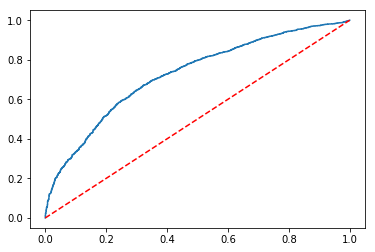

In [59]:
a,b,c=roc_curve(test_df['target'], test_df['p1'])
plt.plot(a,b)
plt.plot([0,1], [0,1], 'r--')

In [60]:
roc_auc_score(test_df['target'], test_df['p1'])
#neki 77 szóval stg is going on
#nekem meg előző hét alapján 0.7249593488803423
#ez a valszínje annak h egy random 0 és random 1 közül az 1nek a p1 értéke a nagyobb, h pont jól különböztetted meg a kettőt p1 alapjá
"""az hogy az eleje meredeket nő azt jelenti hogy az elején még alig keveredik bele rosszul bekategórizált, és amúgy a másik szélén is ilyen
a közepénél mereng és közd jobban
a train df lehet ám az összes eddigi hét is, nem csak a múlt hét"""

0.7249593488803423